In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/NLM-MontgomeryCXRSet.zip'
target_directory = '/content/drive/MyDrive'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the target directory
    zip_ref.extractall(target_directory)

print("File successfully extracted.")


File successfully extracted.


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model


""" Global parameters """
H = 512
W = 512

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "CXR_png", "*.png")))
    masks1 = sorted(glob(os.path.join(path, "ManualMask", "leftMask", "*.png")))
    masks2 = sorted(glob(os.path.join(path, "ManualMask", "rightMask", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y1, valid_y1 = train_test_split(masks1, test_size=split_size, random_state=42)
    train_y2, valid_y2 = train_test_split(masks2, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y1, test_y1 = train_test_split(train_y1, test_size=split_size, random_state=42)
    train_y2, test_y2 = train_test_split(train_y2, test_size=split_size, random_state=42)

    return (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path1, path2):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 + x2
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y1, y2):
    def _parse(x, y1, y2):
        x = x.numpy().decode()
        y1 = y1.numpy().decode()
        y2 = y2.numpy().decode()

        x = read_image(x)
        y = read_mask(y1, y2)
        return x, y

    x, y = tf.py_function(_parse, [x, y1, y2], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y1, Y2, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1, Y2))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/files")

    """ Hyperparameters """
    batch_size = 2
    lr = 1e-5
    num_epochs = 10
    model_path = "/content/drive/MyDrive/files/model.h5"
    csv_path = "/content/drive/MyDrive/files/data.csv"

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/MontgomerySet"
    (train_x, train_y1, train_y2), (valid_x, valid_y1, valid_y2), (test_x, test_y1, test_y2) = load_data(dataset_path)

    train_dataset = tf_dataset(train_x, train_y1, train_y2, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y1, valid_y2, batch=batch_size)

    train_steps = len(train_x)//batch_size
    valid_steps = len(valid_x)//batch_size

    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
        ModelCheckpoint(model_path),
        CSVLogger(csv_path),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1)
    ]

    model.fit(
        train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=num_epochs,
        callbacks=callbacks
    )

    """ Save the trained model """
    model.save(model_path)


Epoch 1/10
56/56 [==============================] - 99s 1s/step - loss: 0.5374 - dice_coef: 0.4626 - recall: 0.9017 - precision: 0.3746 - val_loss: 0.6370 - val_dice_coef: 0.3630 - val_recall: 1.0000 - val_precision: 0.2582 - lr: 1.0000e-05
Epoch 2/10
56/56 [==============================] - 71s 1s/step - loss: 0.3647 - dice_coef: 0.6353 - recall: 0.9548 - precision: 0.5835 - val_loss: 0.6240 - val_dice_coef: 0.3760 - val_recall: 1.0000 - val_precision: 0.2597 - lr: 1.0000e-05
Epoch 3/10
56/56 [==============================] - 73s 1s/step - loss: 0.2415 - dice_coef: 0.7585 - recall: 0.9725 - precision: 0.8333 - val_loss: 0.6398 - val_dice_coef: 0.3602 - val_recall: 0.8314 - val_precision: 0.3537 - lr: 1.0000e-05
Epoch 4/10
56/56 [==============================] - 68s 1s/step - loss: 0.1824 - dice_coef: 0.8176 - recall: 0.9727 - precision: 0.9093 - val_loss: 0.6523 - val_dice_coef: 0.3477 - val_recall: 0.2974 - val_precision: 0.4016 - lr: 1.0000e-05
Epoch 5/10
56/56 [==================

1/1 [==============================] - 4s 4s/step


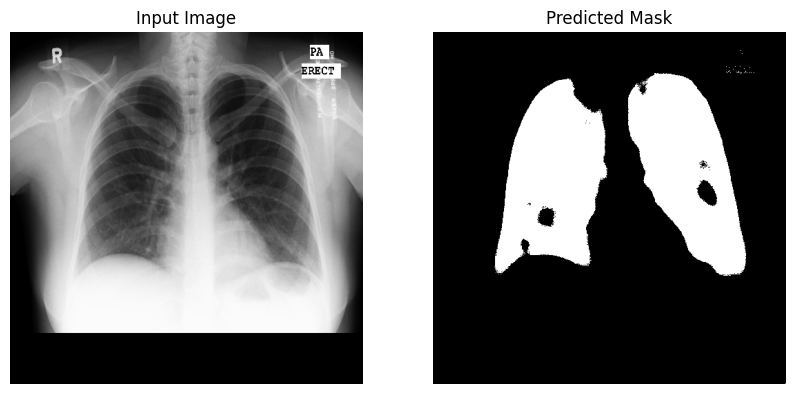

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from keras.models import load_model
from keras.metrics import Recall, Precision
import matplotlib.pyplot as plt

H, W = 512, 512

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def tf_parse(x):
    def _parse(x):
        x = x.decode()
        x = read_image(x)
        return x

    x = tf.numpy_function(_parse, [x], tf.float32)
    x.set_shape([H, W, 3])
    return x

def tf_dataset(X, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    return dataset

def visualize(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    """ Load the trained model """
    model_path = "/content/drive/MyDrive/files/model.h5"

    with tf.keras.utils.custom_object_scope({"dice_loss": dice_loss, "dice_coef": dice_coef, "iou": iou, "Recall": Recall, "Precision": Precision}):
        model = load_model(model_path)

    """ Path to the input image you want to predict """
    input_image_path = "/content/drive/MyDrive/MontgomerySet/CXR_png/MCUCXR_0001_0.png"

    """ Preprocess the input image """
    input_image = read_image(input_image_path)
    input_image = np.expand_dims(input_image, axis=0)

    """ Predict the mask """
    predicted_mask = model.predict(input_image)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold the mask

    """ Visualize the results """
    visualize(input_image[0], predicted_mask)
